In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10, MNIST, CIFAR100
from torchvision.transforms import ToTensor
from sklearn.manifold import TSNE

## Analiza modelu


### VAE

In [12]:
# class VAE(nn.Module):
#     def __init__(self, encoder, decoder, prior, L=16):
#         super(VAE, self).__init__()

#         self.encoder = encoder
#         self.decoder = decoder
#         self.prior = prior
#         self.qz = None
    
#     def forward(self, x, reduction='avg'):
#         x = x.view(x.shape[0], -1)
#         mu_e, log_var_e = self.encoder.encode(x)
#         z = self.encoder.sample(mu_e=mu_e, log_var_e=torch.exp(log_var_e))
        
#         # ELBO
#         RE = self.decoder.log_prob(x, z)
#         if self.prior == 'normal':
#             self.qz = torch.distributions.Normal(mu_e, torch.exp(log_var_e))
#             KL = torch.distributions.kl_divergence(self.qz, torch.distributions.Normal(0, 1)).sum(-1).mean()
#         else:
#             KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu_e=mu_e, log_var_e=torch.exp(log_var_e), z=z)).sum(-1)

        
#         error = 0
#         if np.isnan(RE.detach().numpy()).any():
#             print('RE {}'.format(RE))
#             error = 1
#         if np.isnan(KL.detach().numpy()).any():
#             print('KL {}'.format(KL))
#             error = 1

#         if error == 1:
#             raise ValueError()

#         if reduction == 'sum':
#             return -(RE + KL).sum()
#         else:
#             return -(RE + KL).mean()

#     def sample(self, batch_size=64):
#         if self.prior == 'normal':
#             z = self.qz.sample()
#         else:
#             z = self.prior.sample(batch_size=batch_size)
#         return self.decoder.sample(z)

## GMM Prior

In [13]:

# class GMMPrior(nn.Module):
#     def __init__(self, L, num_components):
#         super(GMMPrior, self).__init__()

#         self.L = L
#         self.num_components = num_components

#         # params
#         self.means = nn.Parameter(torch.randn(num_components, self.L)*32)
#         self.logvars = nn.Parameter(torch.randn(num_components, self.L))

#         # mixing weights
#         self.w = nn.Parameter(torch.zeros(num_components, 1, 1))

#     def get_params(self):
#         return self.means, self.logvars

#     def sample(self, batch_size):
#         # mu, lof_var
#         means, logvars = self.get_params()

#         # mixing probabilities
#         w = F.softmax(self.w, dim=0)
#         w = w.squeeze()

#         # pick components
#         indexes = torch.multinomial(w, batch_size, replacement=True)

#         # means and logvars
#         eps = torch.randn(batch_size, self.L)
#         for i in range(batch_size):
#             indx = indexes[i]
#             if i == 0:
#                 z = means[[indx]] + eps[[i]] * torch.exp(logvars[[indx]])
#             else:
#                 z = torch.cat((z, means[[indx]] + eps[[i]] * torch.exp(logvars[[indx]])), 0)
#         return z

#     def log_prob(self, z):
#         # mu, lof_var
#         means, logvars = self.get_params()

#         # mixing probabilities
#         w = F.softmax(self.w, dim=0)

#         # log-mixture-of-Gaussians
#         z = z.unsqueeze(0) # 1 x B x L
#         means = means.unsqueeze(1) # K x 1 x L
#         logvars = logvars.unsqueeze(1) # K x 1 x L
#         log_p = log_normal_diag(z, means, logvars) + torch.log(w) # K x B x L
#         log_prob = torch.logsumexp(log_p, dim=0, keepdim=False) # B x L

#         return log_prob

In [14]:


# def evaluation(test_loader, name=None, model_best=None, epoch=None):
#     # EVALUATION
#     if model_best is None:
#         # load best performing model
#         model_best = torch.load(name + '.model')

#     model_best.eval()
#     loss = 0.
#     N = 0.
#     for _, test_batch in enumerate(test_loader):
#         loss_t = model_best.forward(test_batch, reduction='sum')
#         loss = loss + loss_t.item()
#         N = N + test_batch.shape[0]
#     loss = loss / N

#     if epoch is None:
#         print(f'FINAL LOSS: nll={loss}')
#     else:
#         print(f'Epoch: {epoch}, val nll={loss}')
#     return loss



# def samples_generated(name, data_loader, extra_name=''):
#     x = next(iter(data_loader)).detach().numpy()

#     # GENERATIONS-------
#     model_best = torch.load(name + '.model')
#     model_best.eval()

#     num_x = 4
#     num_y = 4
#     x = model_best.sample(num_x * num_y)
#     x = x.detach().numpy()

#     fig, ax = plt.subplots(num_x, num_y)
#     for i, ax in enumerate(ax.flatten()):
#         plottable_image = np.reshape(x[i], (32, 32, 3))
#         ax.imshow(plottable_image, cmap='gray')
#         ax.axis('off')

#     plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
#     plt.close()

# def tsne_plot(name, data_loader, extra_name=""):
#     x = next(iter(data_loader)).detach().numpy()

#     # GENERATIONS-------
#     model_best = torch.load(name + '.model')
#     model_best.eval()

#     num_x = 4
#     num_y = 4
#     x = model_best.sample(num_x * num_y)
#     x = x.detach().numpy()
#     model_tsne = TSNE(n_components=2, random_state=0, perplexity=5).fit_transform(x)
#     fig = plt.figure()
#     plt.scatter(model_tsne[:, 0], model_tsne[:, 1])
#     plt.show()
#     plt.savefig(name + '_tsne.pdf', bbox_inches='tight')
#     plt.close()


# def plot_curve(name, nll_val):
#     plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
#     plt.xlabel('epochs')
#     plt.ylabel('nll')
#     plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
#     plt.close()

In [15]:
# def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
#     nll_val = []
#     best_nll = 1000.
#     patience = 0

#     # Main loop
#     for e in range(num_epochs):
#         # TRAINING
#         model.train()
#         for _, batch in enumerate(training_loader):
#             if hasattr(model, 'dequantization'):
#                 if model.dequantization:
#                     batch = batch + torch.rand(batch.shape)
#             loss = model.forward(batch)

#             optimizer.zero_grad()
#             loss.backward(retain_graph=True)
#             optimizer.step()

#         # Validation
#         loss_val = evaluation(val_loader, model_best=model, epoch=e)
#         nll_val.append(loss_val)  # save for plotting

#         if e == 0:
#             print('saved!')
#             torch.save(model, name + '.model')
#             best_nll = loss_val
#         else:
#             if loss_val < best_nll:
#                 print('saved!')
#                 torch.save(model, name + '.model')
#                 best_nll = loss_val
#                 patience = 0

#                 samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
#             else:
#                 patience = patience + 1

#         if patience > max_patience:
#             break

#     nll_val = np.asarray(nll_val)

#     return nll_val

In [16]:

train = CIFAR10('./data', train=True, download=True)
train_data, val_data = torch.utils.data.random_split(train.data.astype(float), [40000, 10000])
test_data = CIFAR10('./data', train=False, download=True)

# train = MNIST('./data', train=True, download=True)
# train_data, val_data = torch.utils.data.random_split(train.data, [50000, 10000])
# test_data = MNIST('./data', train=False, download=True)


# train_data = Digits(mode='train')
# val_data = Digits(mode='val')
# test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)



Files already downloaded and verified
Files already downloaded and verified


In [17]:
from models.GMMPrior import GMMPrior
from models.VAE import Encoder, Decoder, VAE
from src.utils import training, plot_curve, tsne_plot
num_components = 4**2

lr = 1e-3
num_epochs = 10
max_patience = 5
in_features = 32*32*3
hid_dim=256
lat_features = 12

prior = GMMPrior(lat_features,num_components)
encoder = Encoder(n_input_features=in_features, n_hidden_neurons=hid_dim, n_latent_features=lat_features)
decoder = Decoder(n_hidden_neurons=hid_dim, n_latent_features=lat_features, n_output_features=in_features)
vae = VAE(encoder=encoder, decoder=decoder, prior=prior)

optimizer = torch.optim.Adamax(vae.parameters(), lr=lr)




In [18]:
name = 'vae_' + "GMM" + '_' + str(num_components) + '_' + str(lat_features)+'_'+str(hid_dim)+'_'+str(max_patience)
result_dir ='results/' + name + '/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=vae, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)



Epoch: 0, val nll=-366694.4023953672
saved!
Epoch: 1, val nll=-366707.9186761355
saved!
Epoch: 2, val nll=-366714.83471198025
saved!
Epoch: 3, val nll=-366734.90125488775
saved!
Epoch: 4, val nll=-366739.1574045118
saved!
Epoch: 5, val nll=-366742.10397621564
saved!
Epoch: 6, val nll=-366744.3148308455
saved!
Epoch: 7, val nll=-366746.9396689731
saved!
Epoch: 8, val nll=-366747.89924804127
saved!
Epoch: 9, val nll=-366752.99693279364
saved!


In [21]:
plot_curve(nll_val=nll_val, name=result_dir+name)

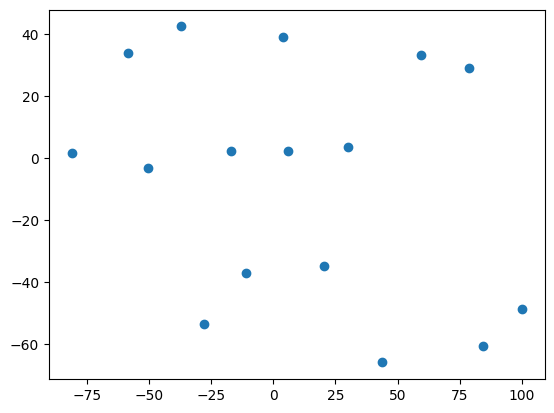

In [22]:
tsne_plot(result_dir + name, training_loader, "model")